In [0]:
import tensorflow as tf
keras, L = tf.keras, tf.keras.layers

import matplotlib.pyplot as plt
import numpy as np

from skimage.transform import resize
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage.transform import resize

import os

In [0]:
!pip3 install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 3.8MB 42.3MB/s 
     |████████████████████████████████| 450kB 72.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [0]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

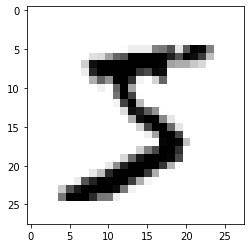

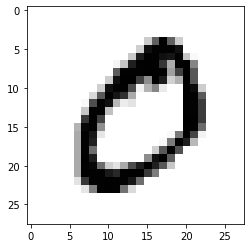

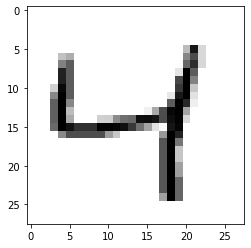

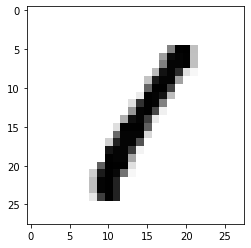

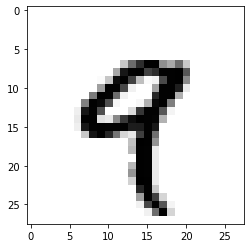

In [0]:
for i in range(5):
    plt.imshow(np.reshape(X[i], (28, 28)), cmap=plt.cm.gray_r)
    plt.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
del X, y

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28))
X_train = np.stack([X_train]*3, axis=-1)
y_train = y_train.astype(int)

X_test = np.reshape(X_test, (X_test.shape[0], 28, 28))
X_test = np.stack([X_test]*3, axis=-1)
y_test = y_test.astype(int)

In [0]:
def init_block(x, filters):
    x = L.Conv2D(filters=filters, kernel_size=1, 
                 input_shape=input_shape, padding="SAME")(x)
    return x

In [0]:
def f(x, filters):
    x = L.BatchNormalization(axis=3)(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(filters=filters, kernel_size=3, padding="SAME")(x)
    x = L.BatchNormalization(axis=3)(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(filters=filters, kernel_size=3, padding="SAME")(x)
    
    return x

def rev_block(x, filters):
    x1, x2 = tf.split(x, num_or_size_splits=2, axis=3)
    y1 = f(x2, filters // 2) + x1
    y2 = f(y1, filters // 2) + x2

    return tf.concat([y1, y2], axis=3)

# Модель с Reversible блоком, но в конце которой находятся Dense слои:

In [0]:
input_shape = X_train.shape[1:]
filters = 32
n_rev_blocks = 1
n_classes = 10

In [0]:
def build_model():
    img_input = L.Input(input_shape)
    x = init_block(img_input, filters)
    for _ in range(n_rev_blocks):
        x = rev_block(x, filters)
    x = L.Flatten()(x)

    x = L.Dense(100)(x)
    x = L.Activation("relu")(x)
    x = L.Dense(n_classes)(x)
    x = L.Activation("softmax")(x)

    model = keras.Model(img_input, x)

    return model

In [0]:
model = build_model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 28, 28, 32)   128         input_5[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_split_4 (TensorFlow [(None, 28, 28, 16), 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 28, 28, 16)   64          tf_op_layer_split_4[0][1]        
____________________________________________________________________________________________

In [0]:
adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52416/52500 [============================>.] - ETA: 0s - loss: 2.3425 - sparse_categorical_accuracy: 0.6589
Epoch 00001: val_loss improved from inf to 0.88950, saving model to revnet_with_dense.hdf5
52500/52500 [==============================] - 13s 243us/sample - loss: 2.3401 - sparse_categorical_accuracy: 0.6591 - val_loss: 0.8895 - val_sparse_categorical_accuracy: 0.7757
Epoch 2/40
52224/52500 [============================>.] - ETA: 0s - loss: 0.6189 - sparse_categorical_accuracy: 0.8334
Epoch 00002: val_loss improved from 0.88950 to 0.40819, saving model to revnet_with_dense.hdf5
52500/52500 [==============================] - 12s 224us/sample - loss: 0.6184 - sparse_categorical_accuracy: 0.8335 - val_loss: 0.4082 - val_sparse_categorical_accuracy: 0.8925
Epoch 3/40
52480/52500 [============================>.] - ETA: 0s - loss: 0.2397 - sparse_categorical_accuracy: 0.9389
Epoch 00003: val_loss improved from 0.40819 to 0.16

**Переобучение сети на маленьком батче:**

In [0]:
model = build_model()

adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

earlystopper = keras.callbacks.EarlyStopping(monitor="loss", patience=5, 
                                             verbose=1)

model.fit(X_train[:32], y_train[:32],
          batch_size=32, epochs=40,
          callbacks=[earlystopper])

Train on 32 samples
Epoch 1/40
32/32 [==============================] - 1s 32ms/sample - loss: 52.8831 - sparse_categorical_accuracy: 0.1562
Epoch 2/40
32/32 [==============================] - 0s 441us/sample - loss: 158.0528 - sparse_categorical_accuracy: 0.4688
Epoch 3/40
32/32 [==============================] - 0s 430us/sample - loss: 188.1282 - sparse_categorical_accuracy: 0.5000
Epoch 4/40
32/32 [==============================] - 0s 432us/sample - loss: 128.7907 - sparse_categorical_accuracy: 0.5312
Epoch 5/40
32/32 [==============================] - 0s 352us/sample - loss: 66.2178 - sparse_categorical_accuracy: 0.6562
Epoch 6/40
32/32 [==============================] - 0s 346us/sample - loss: 22.7801 - sparse_categorical_accuracy: 0.7188
Epoch 7/40
32/32 [==============================] - 0s 340us/sample - loss: 5.4840 - sparse_categorical_accuracy: 0.8438
Epoch 8/40
32/32 [==============================] - 0s 383us/sample - loss: 2.0206 - sparse_categorical_accuracy: 0.9375
Epoc

**LR range test** (https://www.kaggle.com/paultimothymooney/learning-rate-finder-for-keras):

In [0]:
import math
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.backend as K

In [0]:
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        loss = logs['loss']
        self.losses.append(loss)

        if math.isnan(loss) or loss > self.best_loss * 1000:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        self.model.save_weights('tmp.h5')

        original_lr = K.get_value(self.model.optimizer.lr)

        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        self.model.load_weights('tmp.h5')

        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, y_lim=(0, 100)):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.figure(figsize=(12, 8))
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        x = self.lrs[n_skip_beginning:-n_skip_end]
        y = self.losses[n_skip_beginning:-n_skip_end]
        plt.plot(x, y)
        plt.xscale('log')
        plt.ylim(y_lim)

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)


Для SGD:

Train on 52500 samples
16384/52500 [========>.....................] - ETA: 4s - loss: 252.6918 - sparse_categorical_accuracy: 0.4140

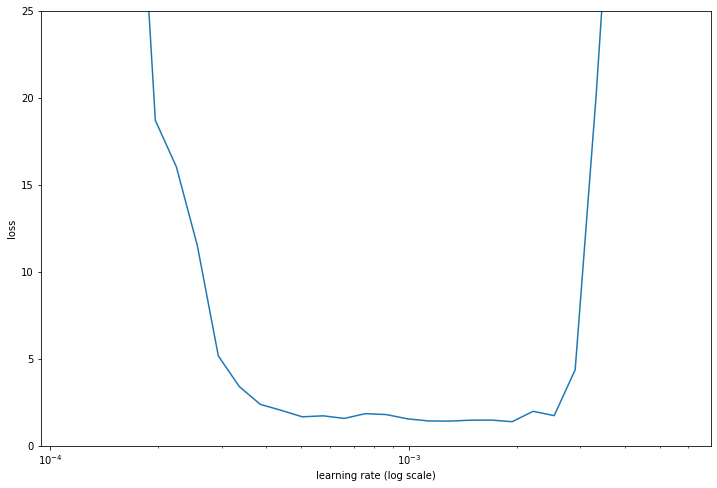

In [0]:
model = build_model()

model.compile(optimizer=keras.optimizers.SGD(),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

lr_finder = LRFinder(model)
lr_finder.find(X_train, y_train, start_lr=0.0001, end_lr=100, batch_size=512, epochs=1)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1, y_lim=(0, 25))
plt.show()

Посмотрим качество обучения для лучших lr:

In [0]:
 model = build_model()
 
 model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_sgd.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52192/52500 [============================>.] - ETA: 0s - loss: 1.1177 - sparse_categorical_accuracy: 0.7969
Epoch 00001: val_loss improved from inf to 0.57685, saving model to revnet_with_dense_sgd.hdf5
52500/52500 [==============================] - 11s 218us/sample - loss: 1.1140 - sparse_categorical_accuracy: 0.7974 - val_loss: 0.5769 - val_sparse_categorical_accuracy: 0.8753
Epoch 2/40
52448/52500 [============================>.] - ETA: 0s - loss: 0.4586 - sparse_categorical_accuracy: 0.8939
Epoch 00002: val_loss improved from 0.57685 to 0.45376, saving model to revnet_with_dense_sgd.hdf5
52500/52500 [==============================] - 11s 202us/sample - loss: 0.4585 - sparse_categorical_accuracy: 0.8939 - val_loss: 0.4538 - val_sparse_categorical_accuracy: 0.9013
Epoch 3/40
52480/52500 [============================>.] - ETA: 0s - loss: 0.3565 - sparse_categorical_accuracy: 0.9154
Epoch 00003: val_loss improved from 0.45376

In [0]:
 model = build_model()
 
 model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_sgd.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52480/52500 [============================>.] - ETA: 0s - loss: nan - sparse_categorical_accuracy: 0.0988
Epoch 00001: val_loss did not improve from inf
52500/52500 [==============================] - 12s 231us/sample - loss: nan - sparse_categorical_accuracy: 0.0988 - val_loss: nan - val_sparse_categorical_accuracy: 0.0979
Epoch 2/40
16192/52500 [========>.....................] - ETA: 6s - loss: nan - sparse_categorical_accuracy: 0.0980WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: ignored

В последнем случае SGD функция потерь сразу ушла в nan

Посмотрим то же самое для Adam:

Train on 52500 samples
34816/52500 [==================>...........] - ETA: 1s - loss: 16.5278 - sparse_categorical_accuracy: 0.5558

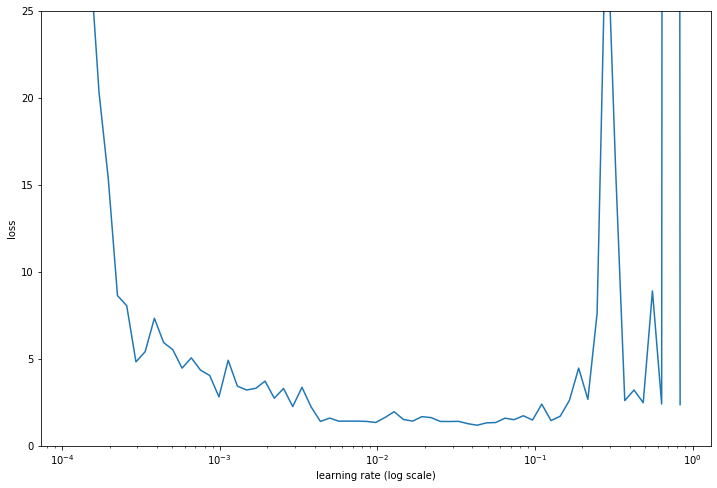

In [0]:
model = build_model()

model.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

lr_finder = LRFinder(model)
lr_finder.find(X_train, y_train, start_lr=0.0001, end_lr=100, batch_size=512, epochs=1)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1, y_lim=(0, 25))
plt.show()

In [0]:
model = build_model()

adam = keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_lr.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52480/52500 [============================>.] - ETA: 0s - loss: 9.8800 - sparse_categorical_accuracy: 0.4767
Epoch 00001: val_loss improved from inf to 1.23393, saving model to revnet_with_dense_lr.hdf5
52500/52500 [==============================] - 12s 238us/sample - loss: 9.8766 - sparse_categorical_accuracy: 0.4767 - val_loss: 1.2339 - val_sparse_categorical_accuracy: 0.6214
Epoch 2/40
52288/52500 [============================>.] - ETA: 0s - loss: 1.7716 - sparse_categorical_accuracy: 0.3961
Epoch 00002: val_loss did not improve from 1.23393
52500/52500 [==============================] - 11s 218us/sample - loss: 1.7735 - sparse_categorical_accuracy: 0.3956 - val_loss: 2.0485 - val_sparse_categorical_accuracy: 0.2289
Epoch 3/40
52288/52500 [============================>.] - ETA: 0s - loss: 2.2555 - sparse_categorical_accuracy: 0.1552
Epoch 00003: val_loss did not improve from 1.23393
52500/52500 [============================

In [0]:
model = build_model()

adam = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_lr.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52288/52500 [============================>.] - ETA: 0s - loss: 2.7939 - sparse_categorical_accuracy: 0.4979
Epoch 00001: val_loss improved from inf to 1.18438, saving model to revnet_with_dense_lr.hdf5
52500/52500 [==============================] - 13s 251us/sample - loss: 2.7865 - sparse_categorical_accuracy: 0.4986 - val_loss: 1.1844 - val_sparse_categorical_accuracy: 0.6418
Epoch 2/40
52416/52500 [============================>.] - ETA: 0s - loss: 0.9230 - sparse_categorical_accuracy: 0.7089
Epoch 00002: val_loss improved from 1.18438 to 0.65049, saving model to revnet_with_dense_lr.hdf5
52500/52500 [==============================] - 12s 222us/sample - loss: 0.9231 - sparse_categorical_accuracy: 0.7090 - val_loss: 0.6505 - val_sparse_categorical_accuracy: 0.7808
Epoch 3/40
52256/52500 [============================>.] - ETA: 0s - loss: 0.4861 - sparse_categorical_accuracy: 0.8548
Epoch 00003: val_loss improved from 0.65049 t

Лучше себя показало значение по умолчанию равное 0.001

**Среднее, дисперсия и максимальное значение выходов каждого слоя** (https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer):

In [0]:
def count_output_stats(model, data):
    inp = model.input                                         
    outputs = [layer.output for layer in model.layers]
    functors = [K.function([inp], [out]) for out in outputs]   

    layer_outs = np.array([func(data)[0] for func in functors])

    print("Layer_name     Mean      Std     AbsMax")
    for out, layer in zip(layer_outs, model.layers):
        print(layer.name, np.mean(out), np.std(out), np.max(np.abs(out)))

In [0]:
model = keras.models.load_model('revnet_with_dense.hdf5')
count_output_stats(model, X_train[:32])

Layer_name     Mean      Std     AbsMax
input_26 33.669403 78.76575 255.0
conv2d_125 0.34469685 3.6137059 25.740976
tf_op_layer_split_25 0.34469682 3.6137064 25.740976
batch_normalization_100 -0.040776733 1.0181673 3.634192
activation_147 0.3284836 0.7104299 3.634192
conv2d_126 -0.20385407 3.2157915 20.416842
batch_normalization_101 -0.18014385 1.0640172 5.8735495
activation_148 0.23189177 0.664201 5.593438
conv2d_127 -0.06973644 2.491622 19.98863
tf_op_layer_add_50 0.32768622 2.2203338 17.570183
batch_normalization_102 -0.147246 0.9671924 8.543778
activation_149 0.22942124 0.66501045 8.543778
conv2d_128 0.060606577 2.08692 17.628712
batch_normalization_103 -0.20750129 1.1196847 8.575382
activation_150 0.22977695 0.7793017 8.126232
conv2d_129 -0.10059774 3.0193844 30.934013
tf_op_layer_add_51 0.19137326 2.74274 25.824512
tf_op_layer_concat_25 0.2595297 2.496176 25.824512
flatten_25 0.2595297 2.496176 25.824512
dense_44 -149.66223 137.3638 826.3128
activation_151 3.0253463 26.151455 470

**Grad norms** (https://stackoverflow.com/questions/57759635/get-gradients-with-keras-tensorflow-2-0):

In [0]:
class GradientCallback(tf.keras.callbacks.Callback):

    def on_batch_end(self, batch, logs=None):
        loss = self.model.total_loss
        optimizer = self.model.optimizer
        gradients = optimizer.get_gradients(loss, self.model.trainable_weights)
        for t in gradients:
            print('Tensor: {}'.format(t.name))
            print('{}\n'.format(t.numpy()[:10]))

Данный код кидает ошибку:

In [0]:
model = build_model()

adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

gradient_callback = GradientCallback()

model.fit(X_train, y_train,
          batch_size=32, epochs=1, 
          validation_data=(X_test, y_test),
          callbacks=[gradient_callback])

Train on 52500 samples, validate on 17500 samples
Tensor: Adam/gradients_39/gradients/conv2d_161/Conv2D_grad/Conv2DBackpropFilter:0
    0/52500 [..............................] - ETA: 0s

AttributeError: ignored

**Свой training loop** (https://www.tensorflow.org/guide/keras/train_and_evaluate):

In [0]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [0]:
model = build_model()

optimizer = keras.optimizers.Adam()
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()

epochs = 3
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

    # Open a GradientTape to record the operations run
    # during the forward pass, which enables autodifferentiation.
    with tf.GradientTape() as tape:

      # Run the forward pass of the layer.
      # The operations that the layer applies
      # to its inputs are going to be recorded
      # on the GradientTape.
      logits = model(x_batch_train, training=True)  # Logits for this minibatch

      # Compute the loss value for this minibatch.
      loss_value = loss_fn(y_batch_train, logits)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Log every 200 batches.
    if step % 200 == 0:
        print(logits)
        print(y_batch_train)
        print(train_acc_metric(y_batch_train, logits))
        print([tf.norm(grad).numpy() for grad in grads])
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * 64))

  train_acc = train_acc_metric.result()
  print('Training acc over epoch: %s' % (float(train_acc),))

Start of epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0002707e-06 6.7088198e-36 4.2565485e-15
  0.0000000e+00 9.9999905e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 2.9756083e-26 1.5139476e-26 0.0000000e+00 3.6670054e-19
  0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0

KeyboardInterrupt: ignored

Непонятно почему вырождается в константную модель, хотя вроде с теми же оптимизаторами и функциями потерь обычный fit работает нормально:

In [0]:
model = build_model()

adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.fit(X_train, y_train,
          batch_size=32, epochs=1, 
          validation_data=(X_test, y_test))

Train on 52500 samples, validate on 17500 samples
52500/52500 [==============================] - 13s 255us/sample - loss: 2.5533 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.6652 - val_sparse_categorical_accuracy: 0.8377


# Атака на tinyImageNet:

In [0]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip &> log

--2020-02-17 08:53:42--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.1’

tiny-imagenet-200.z 100%[===================>] 236.61M  91.7MB/s    in 2.6s    

2020-02-17 08:53:44 (91.7 MB/s) - ‘tiny-imagenet-200.zip.1’ saved [248100043/248100043]



In [0]:
num_classes = 20
wnids_file = os.path.join("tiny-imagenet-200", 'wnids.txt')
with open(wnids_file, 'r') as f:
    wnids = [x.strip() for x in f]

wnids = wnids[:num_classes]
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

In [0]:

X_train = []
y_train = []
for i, wnid in enumerate(wnids):
    boxes_file = os.path.join("tiny-imagenet-200", 'train', wnid, '%s_boxes.txt' % wnid)
    with open(boxes_file, 'r') as f:
        filenames = [x.split('\t')[0] for x in f]
    num_images = len(filenames)
    
    X_train_block = np.zeros((num_images, 64, 64, 3), dtype=np.int64)
    
    y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
    for j, img_file in enumerate(filenames):
        img_file = os.path.join("tiny-imagenet-200", 'train', wnid, 'images', img_file)
        img = plt.imread(img_file)
        if img.ndim == 2:
            img.shape = (64, 64, 1)

        X_train_block[j] = img

    X_train.append(X_train_block)
    y_train.append(y_train_block)
      
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

In [0]:
indeces = np.arange(len(X_train))
np.random.shuffle(indeces)
X_train = np.resize(X_train[indeces], (len(indeces), 64, 64, 3)) / 255.
y_train = np.resize(y_train[indeces], (len(indeces),))

Class : 8


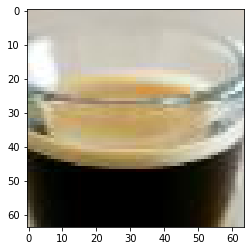


Class : 13


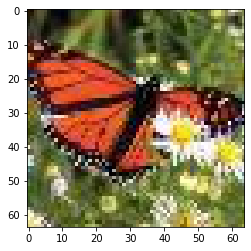


Class : 14


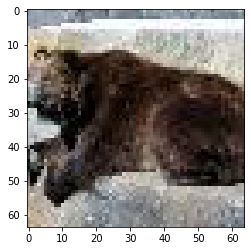


Class : 6


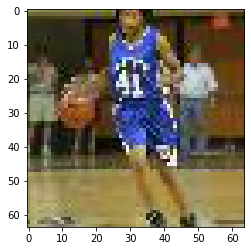


Class : 13


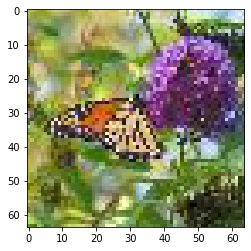

In [0]:
for i in range(5):
    print("Class :", y_train[i])
    plt.imshow(X_train[i])
    plt.show()
    print()

In [0]:
with open(os.path.join("tiny-imagenet-200", 'val', 'val_annotations.txt'), 'r') as f:
    img_files = []
    val_wnids = []
    for line in f:
        if line.split()[1] in wnids:
            img_file, wnid = line.split('\t')[:2]
            img_files.append(img_file)
            val_wnids.append(wnid)
    num_val = len(img_files)
    y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
    
    X_val = np.zeros((num_val, 64, 64, 3), dtype=np.int64)
 
    for i, img_file in enumerate(img_files):
        img_file = os.path.join("tiny-imagenet-200", 'val', 'images', img_file)
        img = plt.imread(img_file)
        if img.ndim == 2:
            img.shape = (64, 64, 1)

        X_val[i] = img

In [0]:
indeces = np.arange(len(X_val))
np.random.shuffle(indeces)
X_val = np.resize(X_val[indeces], (len(indeces), 64, 64, 3)) / 255.
y_val = np.resize(y_val[indeces], (len(indeces),))

In [0]:
input_shape = X_train.shape[1:]
filters = 32
n_rev_blocks = 1
n_classes = 20

In [0]:
def build_model(dropout=0):
    img_input = L.Input(input_shape)
    x = init_block(img_input, filters)
    for _ in range(n_rev_blocks):
        x = rev_block(x, filters)
    x = L.Flatten()(x)

    x = L.Dense(100)(x)
    x = L.Activation("relu")(x)

    if dropout:
        x = L.Dropout(dropout)(x)

    x = L.Dense(n_classes)(x)
    x = L.Activation("softmax")(x)

    model = keras.Model(img_input, x)

    return model

In [0]:
model = build_model(dropout=0.3)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 64, 64, 32)   128         input_9[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_split_8 (TensorFlow [(None, 64, 64, 16), 0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 64, 64, 16)   64          tf_op_layer_split_8[0][1]        
____________________________________________________________________________________________

In [0]:
model = build_model()

sgd = keras.optimizers.SGD()
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_imagenet.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer, earlystopper])

Train on 10000 samples, validate on 1000 samples
Epoch 1/40
 9984/10000 [============================>.] - ETA: 0s - loss: 3.7537 - sparse_categorical_accuracy: 0.1167
Epoch 00001: val_loss improved from inf to 2.97838, saving model to revnet_with_dense_imagenet.hdf5
10000/10000 [==============================] - 5s 549us/sample - loss: 3.7520 - sparse_categorical_accuracy: 0.1169 - val_loss: 2.9784 - val_sparse_categorical_accuracy: 0.1210
Epoch 2/40
 9952/10000 [============================>.] - ETA: 0s - loss: 2.4001 - sparse_categorical_accuracy: 0.2805
Epoch 00002: val_loss improved from 2.97838 to 2.41224, saving model to revnet_with_dense_imagenet.hdf5
10000/10000 [==============================] - 5s 450us/sample - loss: 2.3981 - sparse_categorical_accuracy: 0.2810 - val_loss: 2.4122 - val_sparse_categorical_accuracy: 0.2700
Epoch 3/40
 9888/10000 [============================>.] - ETA: 0s - loss: 1.8793 - sparse_categorical_accuracy: 0.4349
Epoch 00003: val_loss did not improv

In [0]:
model = build_model(dropout=0.3)

sgd = keras.optimizers.SGD()
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_imagenet.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer, earlystopper])

Train on 10000 samples, validate on 1000 samples
Epoch 1/40
 9920/10000 [============================>.] - ETA: 0s - loss: 2.7339 - sparse_categorical_accuracy: 0.1964
Epoch 00001: val_loss improved from inf to 2.95664, saving model to revnet_with_dense_imagenet.hdf5
10000/10000 [==============================] - 5s 524us/sample - loss: 2.7311 - sparse_categorical_accuracy: 0.1972 - val_loss: 2.9566 - val_sparse_categorical_accuracy: 0.1290
Epoch 2/40
 9888/10000 [============================>.] - ETA: 0s - loss: 2.0761 - sparse_categorical_accuracy: 0.3731
Epoch 00002: val_loss improved from 2.95664 to 2.39497, saving model to revnet_with_dense_imagenet.hdf5
10000/10000 [==============================] - 4s 446us/sample - loss: 2.0752 - sparse_categorical_accuracy: 0.3733 - val_loss: 2.3950 - val_sparse_categorical_accuracy: 0.3110
Epoch 3/40
 9952/10000 [============================>.] - ETA: 0s - loss: 1.3745 - sparse_categorical_accuracy: 0.5822
Epoch 00003: val_loss did not improv

In [0]:
model = build_model(dropout=0.5)

sgd = keras.optimizers.SGD()
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_imagenet.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer, earlystopper])

Train on 10000 samples, validate on 1000 samples
Epoch 1/40
 9952/10000 [============================>.] - ETA: 0s - loss: 2.9146 - sparse_categorical_accuracy: 0.1248
Epoch 00001: val_loss improved from inf to 2.99395, saving model to revnet_with_dense_imagenet.hdf5
10000/10000 [==============================] - 6s 563us/sample - loss: 2.9133 - sparse_categorical_accuracy: 0.1252 - val_loss: 2.9940 - val_sparse_categorical_accuracy: 0.0770
Epoch 2/40
 9888/10000 [============================>.] - ETA: 0s - loss: 2.5648 - sparse_categorical_accuracy: 0.2374
Epoch 00002: val_loss improved from 2.99395 to 2.43179, saving model to revnet_with_dense_imagenet.hdf5
10000/10000 [==============================] - 4s 445us/sample - loss: 2.5648 - sparse_categorical_accuracy: 0.2373 - val_loss: 2.4318 - val_sparse_categorical_accuracy: 0.3120
Epoch 3/40
 9984/10000 [============================>.] - ETA: 0s - loss: 2.1834 - sparse_categorical_accuracy: 0.3416
Epoch 00003: val_loss improved from 

**Добавим аугментацию:**

In [0]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [0]:
model = build_model()

sgd = keras.optimizers.SGD()
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_imagenet.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, 
                                             verbose=1)

model.fit(datagen.flow(X_train, y_train, batch_size=32),
          epochs=40, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer, earlystopper])

Train for 313 steps, validate on 1000 samples
Epoch 1/40
312/313 [============================>.] - ETA: 0s - loss: 5.5562 - sparse_categorical_accuracy: 0.0591
Epoch 00001: val_loss improved from inf to 2.98101, saving model to revnet_with_dense_imagenet.hdf5
313/313 [==============================] - 14s 46ms/step - loss: 5.5480 - sparse_categorical_accuracy: 0.0589 - val_loss: 2.9810 - val_sparse_categorical_accuracy: 0.0640
Epoch 2/40
310/313 [============================>.] - ETA: 0s - loss: 2.9406 - sparse_categorical_accuracy: 0.0782
Epoch 00002: val_loss improved from 2.98101 to 2.89779, saving model to revnet_with_dense_imagenet.hdf5
313/313 [==============================] - 13s 42ms/step - loss: 2.9407 - sparse_categorical_accuracy: 0.0785 - val_loss: 2.8978 - val_sparse_categorical_accuracy: 0.0850
Epoch 3/40
311/313 [============================>.] - ETA: 0s - loss: 2.8729 - sparse_categorical_accuracy: 0.0985
Epoch 00003: val_loss improved from 2.89779 to 2.87422, saving 

In [0]:
model.fit(datagen.flow(X_train, y_train, batch_size=32),
          epochs=40, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer, earlystopper])

Train for 313 steps, validate on 1000 samples
Epoch 1/40
311/313 [============================>.] - ETA: 0s - loss: 1.7258 - sparse_categorical_accuracy: 0.4738
Epoch 00001: val_loss did not improve from 2.01379
313/313 [==============================] - 13s 40ms/step - loss: 1.7257 - sparse_categorical_accuracy: 0.4740 - val_loss: 2.2213 - val_sparse_categorical_accuracy: 0.4070
Epoch 2/40
310/313 [============================>.] - ETA: 0s - loss: 1.6892 - sparse_categorical_accuracy: 0.4845
Epoch 00002: val_loss did not improve from 2.01379
313/313 [==============================] - 13s 41ms/step - loss: 1.6883 - sparse_categorical_accuracy: 0.4849 - val_loss: 2.2512 - val_sparse_categorical_accuracy: 0.4000
Epoch 3/40
308/313 [============================>.] - ETA: 0s - loss: 1.6868 - sparse_categorical_accuracy: 0.4846
Epoch 00003: val_loss did not improve from 2.01379
313/313 [==============================] - 13s 40ms/step - loss: 1.6892 - sparse_categorical_accuracy: 0.4846 - va

In [0]:
model.fit(datagen.flow(X_train, y_train, batch_size=32),
          epochs=30, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer])

Train for 313 steps, validate on 1000 samples
Epoch 1/30
309/313 [============================>.] - ETA: 0s - loss: 1.5783 - sparse_categorical_accuracy: 0.5164
Epoch 00001: val_loss did not improve from 1.88281
313/313 [==============================] - 12s 40ms/step - loss: 1.5779 - sparse_categorical_accuracy: 0.5165 - val_loss: 2.0534 - val_sparse_categorical_accuracy: 0.4540
Epoch 2/30
309/313 [============================>.] - ETA: 0s - loss: 1.5528 - sparse_categorical_accuracy: 0.5207
Epoch 00002: val_loss did not improve from 1.88281
313/313 [==============================] - 12s 40ms/step - loss: 1.5514 - sparse_categorical_accuracy: 0.5212 - val_loss: 2.0226 - val_sparse_categorical_accuracy: 0.4620
Epoch 3/30
309/313 [============================>.] - ETA: 0s - loss: 1.5563 - sparse_categorical_accuracy: 0.5191
Epoch 00003: val_loss did not improve from 1.88281
313/313 [==============================] - 13s 40ms/step - loss: 1.5547 - sparse_categorical_accuracy: 0.5197 - va

In [0]:
model.fit(datagen.flow(X_train, y_train, batch_size=32),
          epochs=30, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer])

Train for 313 steps, validate on 1000 samples
Epoch 1/30
309/313 [============================>.] - ETA: 0s - loss: 1.4014 - sparse_categorical_accuracy: 0.5656
Epoch 00001: val_loss did not improve from 1.83705
313/313 [==============================] - 13s 41ms/step - loss: 1.4016 - sparse_categorical_accuracy: 0.5651 - val_loss: 1.8851 - val_sparse_categorical_accuracy: 0.4800
Epoch 2/30
309/313 [============================>.] - ETA: 0s - loss: 1.4112 - sparse_categorical_accuracy: 0.5626
Epoch 00002: val_loss did not improve from 1.83705
313/313 [==============================] - 13s 40ms/step - loss: 1.4108 - sparse_categorical_accuracy: 0.5623 - val_loss: 2.1105 - val_sparse_categorical_accuracy: 0.4540
Epoch 3/30
309/313 [============================>.] - ETA: 0s - loss: 1.3804 - sparse_categorical_accuracy: 0.5673
Epoch 00003: val_loss did not improve from 1.83705
313/313 [==============================] - 12s 40ms/step - loss: 1.3821 - sparse_categorical_accuracy: 0.5667 - va

In [0]:
model.fit(datagen.flow(X_train, y_train, batch_size=32),
          epochs=30, 
          validation_data=(X_val, y_val),
          callbacks=[checkpointer])

Train for 313 steps, validate on 1000 samples
Epoch 1/30
311/313 [============================>.] - ETA: 0s - loss: 1.2930 - sparse_categorical_accuracy: 0.5967
Epoch 00001: val_loss did not improve from 1.75622
313/313 [==============================] - 14s 44ms/step - loss: 1.2927 - sparse_categorical_accuracy: 0.5968 - val_loss: 1.8816 - val_sparse_categorical_accuracy: 0.4830
Epoch 2/30
311/313 [============================>.] - ETA: 0s - loss: 1.2962 - sparse_categorical_accuracy: 0.5985
Epoch 00002: val_loss did not improve from 1.75622
313/313 [==============================] - 13s 41ms/step - loss: 1.2957 - sparse_categorical_accuracy: 0.5986 - val_loss: 2.0152 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/30
310/313 [============================>.] - ETA: 0s - loss: 1.2848 - sparse_categorical_accuracy: 0.6024
Epoch 00003: val_loss did not improve from 1.75622
313/313 [==============================] - 13s 42ms/step - loss: 1.2838 - sparse_categorical_accuracy: 0.6022 - va

In [0]:
model.load_weights("revnet_with_dense_imagenet.hdf5")

**Атака:**

In [0]:
def choose_images():
    att_i, ch_i = np.random.randint(len(X_val), size=2)

    attacked_img = X_val[att_i]
    changed_img = X_val[ch_i]

    attacked_img = tf.cast(tf.reshape(attacked_img, [1, *attacked_img.shape]), tf.float32)
    changed_img = tf.cast(tf.reshape(changed_img, [1, *changed_img.shape]), tf.float32)

    print("Attacked image: ")
    print("Logits: ", model(attacked_img).numpy()[0])
    print("Predicted: ", np.argmax(model(attacked_img)[0]))
    print("Real: ", y_val[att_i])
    plt.imshow(attacked_img[0])
    plt.show()

    print("Changing image: ")
    print("Logits: ", model(changed_img).numpy()[0])
    print("Predicted: ", np.argmax(model(changed_img)[0]))
    print("Real: ", y_val[ch_i])
    plt.imshow(changed_img[0])
    plt.show()
    
    return att_i, attacked_img, ch_i, changed_img

In [0]:
def attack(attacked_img, changed_img, eps=1, fn=tf.identity, iterations=40):  
    y = model(attacked_img)

    for i in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(changed_img)
            y_pred = model(changed_img)
            loss = tf.reduce_mean((y - y_pred) ** 2)

        gradients, = tape.gradient(loss, changed_img)
        
        changed_img = tf.clip_by_value(changed_img - eps * fn(gradients), 0, 1)
        if i % 10 == 0:
            print("Loss : ", loss.numpy())
            print("Predict of changing image: ", np.argmax(y_pred[0]))
            print("Logits of changing image: ", y_pred.numpy()[0])
            print("Logits of attacked image: ", y.numpy()[0])
            plt.imshow(changed_img[0, :])
            plt.show()

Attacked image: 
Logits:  [4.29490028e-05 1.99984922e-03 1.47964864e-04 4.43756377e-04
 5.96495454e-07 2.22194423e-08 9.18522710e-05 7.52336717e-08
 9.73554969e-01 3.51550942e-03 6.42894069e-03 1.78731511e-07
 6.99436641e-04 3.58972976e-08 9.24733570e-08 5.58308866e-09
 1.04072485e-02 1.67092064e-03 9.75187926e-04 2.04800454e-05]
Predicted:  8
Real:  8


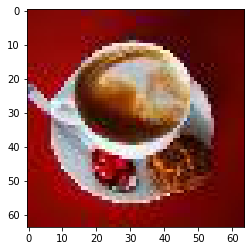

Changing image: 
Logits:  [8.32816437e-02 1.72994449e-04 2.02806760e-03 4.67032474e-03
 1.59660192e-06 1.61584525e-03 1.68312472e-04 8.47714895e-04
 1.38769765e-05 1.52360396e-02 7.08324718e-04 8.45653951e-01
 1.50090980e-03 7.30484589e-06 1.84944700e-02 2.43535146e-06
 6.40398866e-05 2.32682936e-02 1.86341279e-03 4.00469376e-04]
Predicted:  11
Real:  11


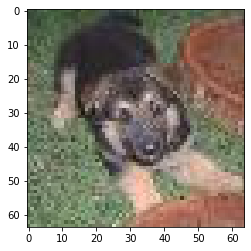

In [0]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.083547816
Predict of changing image:  11
Logits of changing image:  [8.32816437e-02 1.72994449e-04 2.02806760e-03 4.67032474e-03
 1.59660192e-06 1.61584525e-03 1.68312472e-04 8.47714895e-04
 1.38769765e-05 1.52360396e-02 7.08324718e-04 8.45653951e-01
 1.50090980e-03 7.30484589e-06 1.84944700e-02 2.43535146e-06
 6.40398866e-05 2.32682936e-02 1.86341279e-03 4.00469376e-04]
Logits of attacked image:  [4.29490028e-05 1.99984922e-03 1.47964864e-04 4.43756377e-04
 5.96495454e-07 2.22194423e-08 9.18522710e-05 7.52336717e-08
 9.73554969e-01 3.51550942e-03 6.42894069e-03 1.78731511e-07
 6.99436641e-04 3.58972976e-08 9.24733570e-08 5.58308866e-09
 1.04072485e-02 1.67092064e-03 9.75187926e-04 2.04800454e-05]


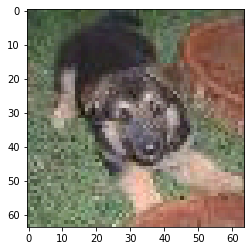

Loss :  0.057110287
Predict of changing image:  11
Logits of changing image:  [5.5799618e-02 1.1417121e-02 5.8313683e-02 1.0720096e-02 1.6372722e-05
 1.2670546e-03 9.9881314e-02 1.1776139e-02 6.7895645e-04 2.4431761e-01
 4.2347033e-02 3.4025031e-01 2.1415250e-02 4.3165119e-04 1.5903478e-02
 1.3624399e-04 7.0918771e-04 4.9618166e-03 3.8485706e-02 4.1171417e-02]
Logits of attacked image:  [4.29490028e-05 1.99984922e-03 1.47964864e-04 4.43756377e-04
 5.96495454e-07 2.22194423e-08 9.18522710e-05 7.52336717e-08
 9.73554969e-01 3.51550942e-03 6.42894069e-03 1.78731511e-07
 6.99436641e-04 3.58972976e-08 9.24733570e-08 5.58308866e-09
 1.04072485e-02 1.67092064e-03 9.75187926e-04 2.04800454e-05]


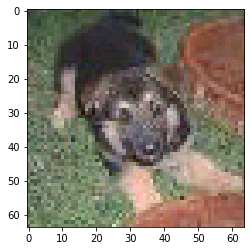

Loss :  0.029047176
Predict of changing image:  8
Logits of changing image:  [0.01470114 0.02508147 0.01521634 0.03802121 0.00039115 0.00105324
 0.02266404 0.00834278 0.25714648 0.09407531 0.08383695 0.02959522
 0.05952618 0.00268656 0.07794375 0.00732783 0.00655551 0.03720463
 0.02287362 0.1957566 ]
Logits of attacked image:  [4.29490028e-05 1.99984922e-03 1.47964864e-04 4.43756377e-04
 5.96495454e-07 2.22194423e-08 9.18522710e-05 7.52336717e-08
 9.73554969e-01 3.51550942e-03 6.42894069e-03 1.78731511e-07
 6.99436641e-04 3.58972976e-08 9.24733570e-08 5.58308866e-09
 1.04072485e-02 1.67092064e-03 9.75187926e-04 2.04800454e-05]


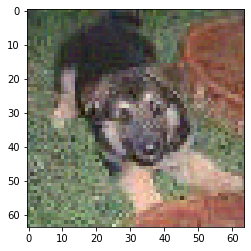

Loss :  0.00018247872
Predict of changing image:  8
Logits of changing image:  [4.0998452e-04 3.2258994e-04 2.6950852e-03 3.3464687e-04 7.5504551e-07
 1.4837620e-06 1.2787188e-03 6.3566658e-05 9.2154646e-01 8.7118726e-03
 2.2989344e-02 4.9554654e-03 1.2797016e-03 1.9518876e-07 1.8866556e-02
 9.4843344e-06 3.0635885e-04 1.3777501e-02 6.8030803e-04 1.7699293e-03]
Logits of attacked image:  [4.29490028e-05 1.99984922e-03 1.47964864e-04 4.43756377e-04
 5.96495454e-07 2.22194423e-08 9.18522710e-05 7.52336717e-08
 9.73554969e-01 3.51550942e-03 6.42894069e-03 1.78731511e-07
 6.99436641e-04 3.58972976e-08 9.24733570e-08 5.58308866e-09
 1.04072485e-02 1.67092064e-03 9.75187926e-04 2.04800454e-05]


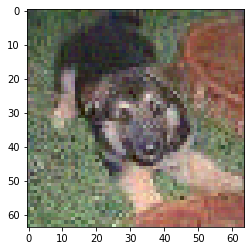

In [0]:
attack(attacked_img, changed_img, eps=0.005, fn=tf.sign)

Attacked image: 
Logits:  [1.4835286e-03 6.3134328e-02 1.1490538e-02 1.2106587e-01 2.4707173e-05
 1.1911738e-02 2.9255864e-03 6.4048576e-03 1.9111481e-03 1.7167993e-02
 5.7189542e-01 1.7731043e-02 9.0072699e-02 8.5489963e-05 6.5457108e-03
 1.9004256e-02 1.6277604e-04 2.8529940e-03 4.8449572e-02 5.6798034e-03]
Predicted:  10
Real:  10


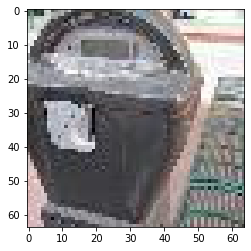

Changing image: 
Logits:  [4.03825892e-04 3.86489206e-03 7.62381824e-04 4.30412329e-04
 1.71595879e-04 1.08860731e-02 1.58409603e-04 9.68694329e-01
 3.64249831e-06 3.91252368e-04 2.14489643e-03 3.81222344e-06
 1.84731362e-05 1.33051035e-05 2.98134655e-05 7.39982876e-04
 4.70490704e-05 3.30774841e-04 9.83806793e-03 1.06709870e-03]
Predicted:  7
Real:  7


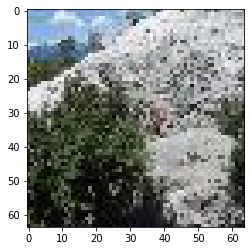

In [0]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.06397055
Predict of changing image:  7
Logits of changing image:  [4.03825892e-04 3.86489206e-03 7.62381824e-04 4.30412329e-04
 1.71595879e-04 1.08860731e-02 1.58409603e-04 9.68694329e-01
 3.64249831e-06 3.91252368e-04 2.14489643e-03 3.81222344e-06
 1.84731362e-05 1.33051035e-05 2.98134655e-05 7.39982876e-04
 4.70490704e-05 3.30774841e-04 9.83806793e-03 1.06709870e-03]
Logits of attacked image:  [1.4835286e-03 6.3134328e-02 1.1490538e-02 1.2106587e-01 2.4707173e-05
 1.1911738e-02 2.9255864e-03 6.4048576e-03 1.9111481e-03 1.7167993e-02
 5.7189542e-01 1.7731043e-02 9.0072699e-02 8.5489963e-05 6.5457108e-03
 1.9004256e-02 1.6277604e-04 2.8529940e-03 4.8449572e-02 5.6798034e-03]


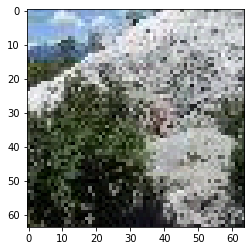

Loss :  0.0005326941
Predict of changing image:  10
Logits of changing image:  [7.7725807e-03 1.5130518e-02 2.1836141e-03 1.4967625e-01 7.0367634e-05
 1.1530259e-02 2.9115463e-04 4.4034626e-03 1.0646121e-04 1.0965350e-03
 6.1250150e-01 1.1532034e-04 6.0627792e-02 4.7250619e-04 1.1395704e-03
 8.2836695e-02 1.6075853e-04 7.8727938e-03 3.5200283e-02 6.8115876e-03]
Logits of attacked image:  [1.4835286e-03 6.3134328e-02 1.1490538e-02 1.2106587e-01 2.4707173e-05
 1.1911738e-02 2.9255864e-03 6.4048576e-03 1.9111481e-03 1.7167993e-02
 5.7189542e-01 1.7731043e-02 9.0072699e-02 8.5489963e-05 6.5457108e-03
 1.9004256e-02 1.6277604e-04 2.8529940e-03 4.8449572e-02 5.6798034e-03]


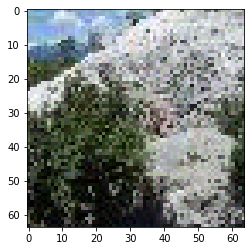

Loss :  0.000747881
Predict of changing image:  10
Logits of changing image:  [1.8300278e-02 9.2312321e-02 5.5253534e-03 5.7576716e-02 7.8956880e-05
 1.6239420e-02 1.0469494e-03 1.0202922e-03 2.1605416e-04 1.5799076e-03
 6.6386622e-01 1.6239854e-04 9.4715841e-02 2.8219775e-03 2.1625247e-03
 5.9514623e-03 1.5899856e-04 3.8982879e-03 2.6703840e-02 5.6622881e-03]
Logits of attacked image:  [1.4835286e-03 6.3134328e-02 1.1490538e-02 1.2106587e-01 2.4707173e-05
 1.1911738e-02 2.9255864e-03 6.4048576e-03 1.9111481e-03 1.7167993e-02
 5.7189542e-01 1.7731043e-02 9.0072699e-02 8.5489963e-05 6.5457108e-03
 1.9004256e-02 1.6277604e-04 2.8529940e-03 4.8449572e-02 5.6798034e-03]


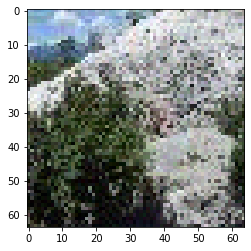

Loss :  0.0094245905
Predict of changing image:  12
Logits of changing image:  [0.02026615 0.04309137 0.03200887 0.2257422  0.00070609 0.02347161
 0.0068704  0.00165433 0.0030498  0.01056669 0.20941676 0.00188041
 0.29423532 0.00791501 0.00693069 0.01470724 0.00196281 0.00703674
 0.03301919 0.05546838]
Logits of attacked image:  [1.4835286e-03 6.3134328e-02 1.1490538e-02 1.2106587e-01 2.4707173e-05
 1.1911738e-02 2.9255864e-03 6.4048576e-03 1.9111481e-03 1.7167993e-02
 5.7189542e-01 1.7731043e-02 9.0072699e-02 8.5489963e-05 6.5457108e-03
 1.9004256e-02 1.6277604e-04 2.8529940e-03 4.8449572e-02 5.6798034e-03]


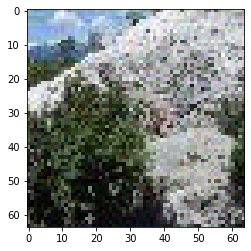

In [0]:
attack(attacked_img, changed_img, eps=0.005, fn=tf.sign)

Attacked image: 
Logits:  [4.20371160e-12 9.77479928e-08 1.95483477e-10 1.93889900e-08
 1.62832359e-10 5.14256104e-09 7.68912756e-09 1.35610856e-10
 4.23664467e-14 1.85423659e-08 6.08102804e-11 1.13113414e-10
 6.43271113e-12 9.99999762e-01 3.79512068e-13 5.08888320e-10
 1.36962945e-12 2.17710789e-12 1.39106348e-07 6.31171959e-09]
Predicted:  13
Real:  13


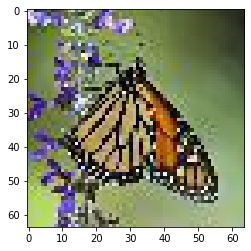

Changing image: 
Logits:  [2.7090347e-05 7.0014806e-03 9.8743236e-05 9.6937883e-01 3.3468622e-10
 9.3174901e-07 5.6934252e-05 7.0301866e-07 8.0902137e-05 3.6153078e-04
 3.3564968e-03 4.4070083e-07 4.3079741e-03 1.9045649e-05 1.6484764e-06
 1.3181940e-04 2.0302332e-07 3.2878582e-08 9.7086733e-05 1.5078281e-02]
Predicted:  3
Real:  3


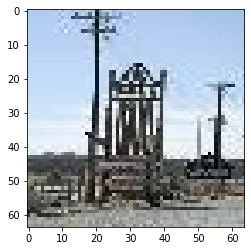

In [0]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.09699815
Predict of changing image:  3
Logits of changing image:  [2.7090347e-05 7.0014806e-03 9.8743236e-05 9.6937883e-01 3.3468622e-10
 9.3174901e-07 5.6934252e-05 7.0301866e-07 8.0902137e-05 3.6153078e-04
 3.3564968e-03 4.4070083e-07 4.3079741e-03 1.9045649e-05 1.6484764e-06
 1.3181940e-04 2.0302332e-07 3.2878582e-08 9.7086733e-05 1.5078281e-02]
Logits of attacked image:  [4.20371160e-12 9.77479928e-08 1.95483477e-10 1.93889900e-08
 1.62832359e-10 5.14256104e-09 7.68912756e-09 1.35610856e-10
 4.23664467e-14 1.85423659e-08 6.08102804e-11 1.13113414e-10
 6.43271113e-12 9.99999762e-01 3.79512068e-13 5.08888320e-10
 1.36962945e-12 2.17710789e-12 1.39106348e-07 6.31171959e-09]


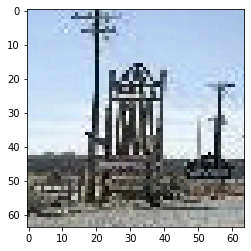

Loss :  2.5089247e-10
Predict of changing image:  13
Logits of changing image:  [6.1558245e-07 1.8004219e-05 5.0878098e-06 4.5599782e-06 9.8130435e-08
 7.7928198e-06 3.1599727e-06 2.1781789e-06 1.7218109e-07 3.6133720e-06
 6.7927579e-07 1.2282541e-07 1.2096858e-07 9.9993360e-01 3.4062543e-07
 3.5243488e-07 2.3599361e-07 1.4974596e-07 1.1017310e-05 8.1053831e-06]
Logits of attacked image:  [4.20371160e-12 9.77479928e-08 1.95483477e-10 1.93889900e-08
 1.62832359e-10 5.14256104e-09 7.68912756e-09 1.35610856e-10
 4.23664467e-14 1.85423659e-08 6.08102804e-11 1.13113414e-10
 6.43271113e-12 9.99999762e-01 3.79512068e-13 5.08888320e-10
 1.36962945e-12 2.17710789e-12 1.39106348e-07 6.31171959e-09]


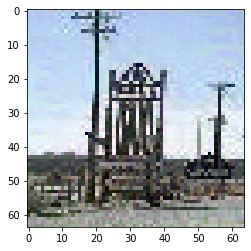

Loss :  2.798637e-16
Predict of changing image:  13
Logits of changing image:  [1.0437424e-10 3.4801239e-08 5.0052238e-09 8.4815452e-09 2.1706044e-10
 1.9945940e-08 1.2503958e-09 1.2710664e-08 6.8191633e-11 6.3394454e-09
 4.0454662e-10 3.0324507e-11 4.9025801e-11 9.9999976e-01 2.3217733e-10
 1.9932460e-10 8.0113144e-10 2.8947494e-11 1.1008899e-07 1.5383279e-08]
Logits of attacked image:  [4.20371160e-12 9.77479928e-08 1.95483477e-10 1.93889900e-08
 1.62832359e-10 5.14256104e-09 7.68912756e-09 1.35610856e-10
 4.23664467e-14 1.85423659e-08 6.08102804e-11 1.13113414e-10
 6.43271113e-12 9.99999762e-01 3.79512068e-13 5.08888320e-10
 1.36962945e-12 2.17710789e-12 1.39106348e-07 6.31171959e-09]


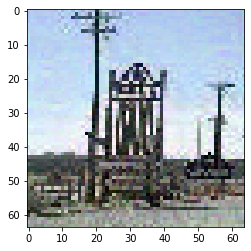

Loss :  3.669905e-15
Predict of changing image:  13
Logits of changing image:  [7.2837382e-17 2.2744546e-09 5.5147017e-13 1.1111250e-12 1.8872584e-13
 2.6821574e-12 3.9765761e-14 4.6687341e-11 2.0289048e-16 2.3281052e-11
 6.9970120e-13 4.4859580e-18 6.2645070e-15 1.0000000e+00 1.3815901e-14
 1.2309570e-12 3.3450334e-13 1.2681495e-18 5.7874576e-08 2.9862021e-10]
Logits of attacked image:  [4.20371160e-12 9.77479928e-08 1.95483477e-10 1.93889900e-08
 1.62832359e-10 5.14256104e-09 7.68912756e-09 1.35610856e-10
 4.23664467e-14 1.85423659e-08 6.08102804e-11 1.13113414e-10
 6.43271113e-12 9.99999762e-01 3.79512068e-13 5.08888320e-10
 1.36962945e-12 2.17710789e-12 1.39106348e-07 6.31171959e-09]


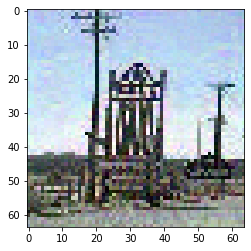

In [0]:
attack(attacked_img, changed_img, eps=0.005, fn=tf.sign)

# Модель с Reversible блоком, где в конце выбирается 10 чисел из равномерной сетки:

In [0]:
input_shape = X_train.shape[1:]
filters = 32
n_rev_blocks = 1
n_classes = 10

def build_model():
    img_input = L.Input(input_shape)
    x = init_block(img_input, filters)
    for _ in range(n_rev_blocks):
        x = rev_block(x, filters)
    x = L.Flatten()(x)

    positions = tf.range(0, x.shape[-1], x.shape[-1] // n_classes + 1)
    x = tf.reshape(tf.convert_to_tensor([x[:, i] for i in positions]), (-1, n_classes))
    x = L.Activation("softmax")(x)

    model = keras.Model(img_input, x)
    return model

In [0]:
model = build_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 28, 28, 32)   128         input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_split_3 (TensorFlow [(None, 28, 28, 16), 0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 28, 28, 16)   64          tf_op_layer_split_3[0][1]        
____________________________________________________________________________________________

**Переобучение модели на маленьком батче:**

In [0]:
model = build_model()

adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.fit(X_train[:32], y_train[:32],
          batch_size=32, epochs=40,)

Train on 32 samples
Epoch 1/40
32/32 [==============================] - 1s 31ms/sample - loss: 36.3624 - sparse_categorical_accuracy: 0.0938
Epoch 2/40
32/32 [==============================] - 0s 402us/sample - loss: 35.5335 - sparse_categorical_accuracy: 0.0625
Epoch 3/40
32/32 [==============================] - 0s 351us/sample - loss: 34.6310 - sparse_categorical_accuracy: 0.1562
Epoch 4/40
32/32 [==============================] - 0s 382us/sample - loss: 30.1114 - sparse_categorical_accuracy: 0.1250
Epoch 5/40
32/32 [==============================] - 0s 356us/sample - loss: 26.2750 - sparse_categorical_accuracy: 0.2812
Epoch 6/40
32/32 [==============================] - 0s 346us/sample - loss: 26.6770 - sparse_categorical_accuracy: 0.0938
Epoch 7/40
32/32 [==============================] - 0s 326us/sample - loss: 15.6507 - sparse_categorical_accuracy: 0.0312
Epoch 8/40
32/32 [==============================] - 0s 313us/sample - loss: 29.8816 - sparse_categorical_accuracy: 0.0625
Epoch

**На всех данных:**

In [0]:
model = build_model()

adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.fit(X_train, y_train,
          batch_size=32, epochs=8, 
          validation_data=(X_test, y_test))

Train on 52500 samples, validate on 17500 samples
Epoch 1/8
52500/52500 [==============================] - 13s 239us/sample - loss: 2.8786 - sparse_categorical_accuracy: 0.1002 - val_loss: 2.3615 - val_sparse_categorical_accuracy: 0.1015
Epoch 2/8
52500/52500 [==============================] - 11s 219us/sample - loss: 2.3411 - sparse_categorical_accuracy: 0.0995 - val_loss: 2.3501 - val_sparse_categorical_accuracy: 0.1008
Epoch 3/8
52500/52500 [==============================] - 11s 219us/sample - loss: 2.3390 - sparse_categorical_accuracy: 0.0984 - val_loss: 2.3363 - val_sparse_categorical_accuracy: 0.1019
Epoch 4/8
52500/52500 [==============================] - 12s 221us/sample - loss: 2.3364 - sparse_categorical_accuracy: 0.1010 - val_loss: 2.3389 - val_sparse_categorical_accuracy: 0.1045
Epoch 5/8
52500/52500 [==============================] - 11s 219us/sample - loss: 2.3341 - sparse_categorical_accuracy: 0.1025 - val_loss: 2.3348 - val_sparse_categorical_accuracy: 0.1013
Epoch 6/8


**LR range test:**

Train on 52500 samples
41472/52500 [======================>.......] - ETA: 1s - loss: 472.2243 - sparse_categorical_accuracy: 0.0996

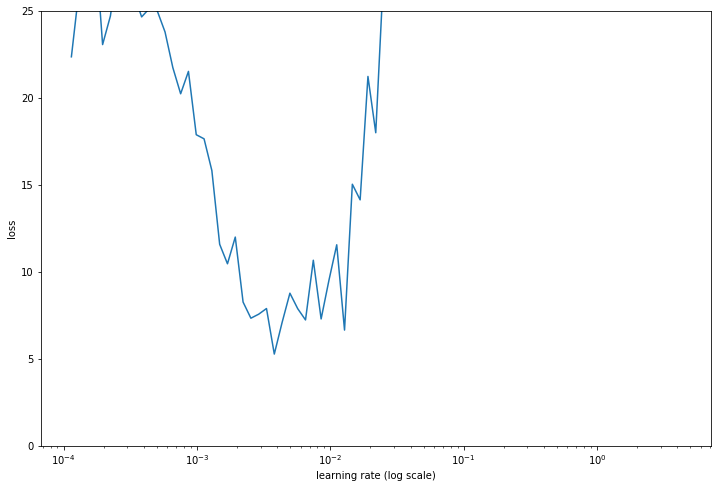

In [0]:
model = build_model()

model.compile(optimizer=keras.optimizers.SGD(),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

lr_finder = LRFinder(model)
lr_finder.find(X_train, y_train, start_lr=0.0001, end_lr=100, batch_size=512, epochs=1)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1, y_lim=(0, 25))
plt.show()

In [0]:
model = build_model()

model.compile(optimizer=keras.optimizers.SGD(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.fit(X_train, y_train,
          batch_size=32, epochs=8, 
          validation_data=(X_test, y_test))

Train on 52500 samples, validate on 17500 samples
Epoch 1/8
52500/52500 [==============================] - 12s 230us/sample - loss: 3.4716 - sparse_categorical_accuracy: 0.1003 - val_loss: 3.8311 - val_sparse_categorical_accuracy: 0.0994
Epoch 2/8
52500/52500 [==============================] - 11s 211us/sample - loss: 3.2511 - sparse_categorical_accuracy: 0.0980 - val_loss: 4.5026 - val_sparse_categorical_accuracy: 0.0989
Epoch 3/8
52500/52500 [==============================] - 11s 210us/sample - loss: 3.2418 - sparse_categorical_accuracy: 0.0996 - val_loss: 3.2410 - val_sparse_categorical_accuracy: 0.0984
Epoch 4/8
52500/52500 [==============================] - 11s 210us/sample - loss: 3.1874 - sparse_categorical_accuracy: 0.1004 - val_loss: 3.8680 - val_sparse_categorical_accuracy: 0.0993
Epoch 5/8
52500/52500 [==============================] - 11s 210us/sample - loss: 3.2906 - sparse_categorical_accuracy: 0.1005 - val_loss: 2.6657 - val_sparse_categorical_accuracy: 0.0997
Epoch 6/8


**Статистики:**

In [0]:
count_output_stats(model, X_train[:32])

Layer_name     Mean      Std     AbsMax
input_29 33.669403 78.76575 255.0
conv2d_140 4.231854 29.188667 210.1025
tf_op_layer_split_28 4.231854 29.188667 210.1025
batch_normalization_112 -0.060708497 1.01179 4.95125
activation_163 0.28781343 0.6900325 2.853308
conv2d_141 -0.15365316 0.9361949 5.795438
batch_normalization_113 -0.1363029 0.9564958 5.326945
activation_164 0.2682067 0.480782 4.5242367
conv2d_142 0.050192434 0.49655452 4.2259264
tf_op_layer_add_56 3.7044044 27.961082 196.4603
batch_normalization_114 0.013626135 0.9481851 3.6829545
activation_165 0.32152814 0.66628516 3.3332853
conv2d_143 0.06382023 0.87668425 5.9434075
batch_normalization_115 -0.0071410853 0.93496156 5.801188
activation_166 0.32338476 0.619174 5.801188
conv2d_144 -0.053391617 0.6353927 4.3104606
tf_op_layer_add_57 4.756104 30.14578 209.5515
tf_op_layer_concat_28 4.2302537 29.078714 209.5515
flatten_28 4.2302537 29.078714 209.5515
tf_op_layer_strided_slice_50 0.0699166 0.0 0.0699166
tf_op_layer_strided_slice_

В данной моделе видно, что она не может обучиться даже на маленьком батче, нужно исправлять модель.